In [1]:
import time

import torch

from src.data import batch_dataset, load_data, split_data
from src.lstm import MCDLSTM, train_mcdlstm
from torch.utils.data import TensorDataset, DataLoader

from matplotlib import pyplot as plt

df = load_data()
dataset = split_data(
    df,
    without_cols=[
        "Timestamp",
        "Light1",
        "Light2",
        "Light3",
        "Light4",
    ],
    scale="normalize",
)
seq_dataset = batch_dataset(dataset, sequence_length=10, overlap_series=True)

(x_train, y_train), (x_test, y_test) = dataset
(seq_x_train, seq_y_train), (seq_x_test, seq_y_test) = seq_dataset

## Z regresją

 38%|███▊      | 19/50 [08:58<14:37, 28.32s/it]

Early stop.
Best dev loss: 0.22632145103500242
MSE: 0.226, r2: 0.852, f1 macro: 0.407
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       702
         1.0       0.00      0.00      0.00         0
         2.0       0.23      0.42      0.29        93
         3.0       0.46      0.27      0.34       192

    accuracy                           0.79       987
   macro avg       0.42      0.42      0.41       987
weighted avg       0.82      0.79      0.80       987



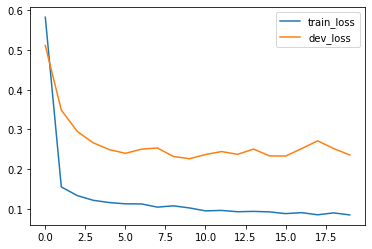

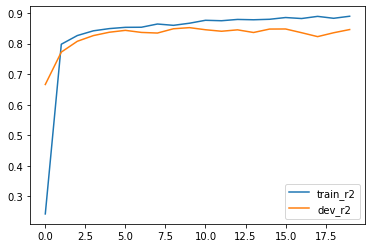

In [7]:
device = 'cuda:0'

train_ds = TensorDataset(seq_x_train, seq_y_train)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

test_ds = TensorDataset(seq_x_test, seq_y_test)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

mcdLSTM_regr = MCDLSTM(no_layers=3, input_size=12, hidden_dim=64, output_dim=1, drop_prob=0.5, device=device).to(device)

mse, r2, f1, report = train_mcdlstm(mcdLSTM_regr, train_dl, test_dl, regression=True,
                                    epochs=50, lr=0.00001, patience=10,
                                    save_prefix='models/lstm_model_'+str(int(time.time())),
                                    print_chart=True, print_progress=False, device=device)

print(f'MSE: {mse:.3f}, r2: {r2:.3f}, f1 macro: {f1:.3f}')
print(report)


## Z klasyfikacją

 46%|████▌     | 23/50 [10:20<12:08, 26.98s/it]

Early stop.
Best dev loss: 0.29821223671347086
MSE: 0.298, r2: 0.805, f1 macro: 0.436
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       702
         1.0       0.00      0.00      0.00         0
         2.0       0.21      0.24      0.22        93
         3.0       0.55      0.51      0.53       192

    accuracy                           0.82       987
   macro avg       0.44      0.43      0.44       987
weighted avg       0.84      0.82      0.83       987



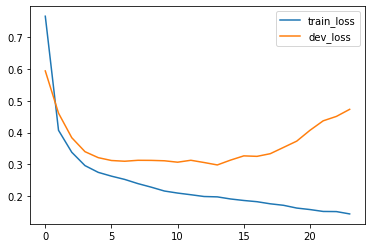

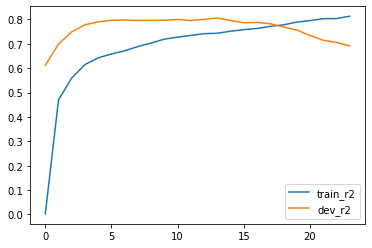

In [5]:
device = 'cuda:0'

train_ds = TensorDataset(seq_x_train, seq_y_train)
train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

test_ds = TensorDataset(seq_x_test, seq_y_test)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)

mcdLSTM_clf = MCDLSTM(no_layers=3, input_size=12, hidden_dim=64, output_dim=4, drop_prob=0.5, device=device).to(device)

mse, r2, f1, report = train_mcdlstm(mcdLSTM_clf, train_dl, test_dl, regression=False,
                                    epochs=50, lr=0.00001, patience=10,
                                    save_prefix='models/lstm_model_'+str(int(time.time())),
                                    print_chart=True, print_progress=False, device=device)

print(f'MSE: {mse:.3f}, r2: {r2:.3f}, f1 macro: {f1:.3f}')
print(report)

# Niepewności (regresja)

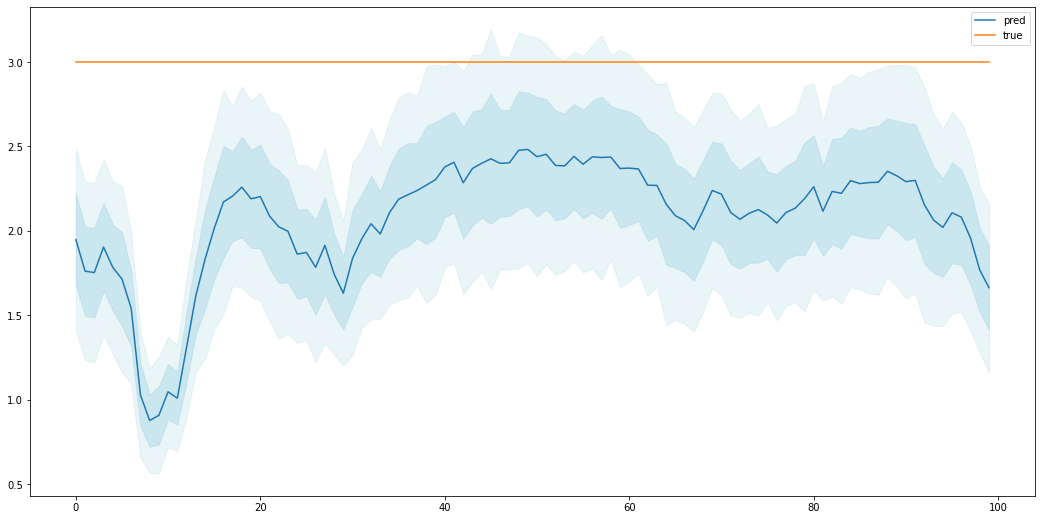

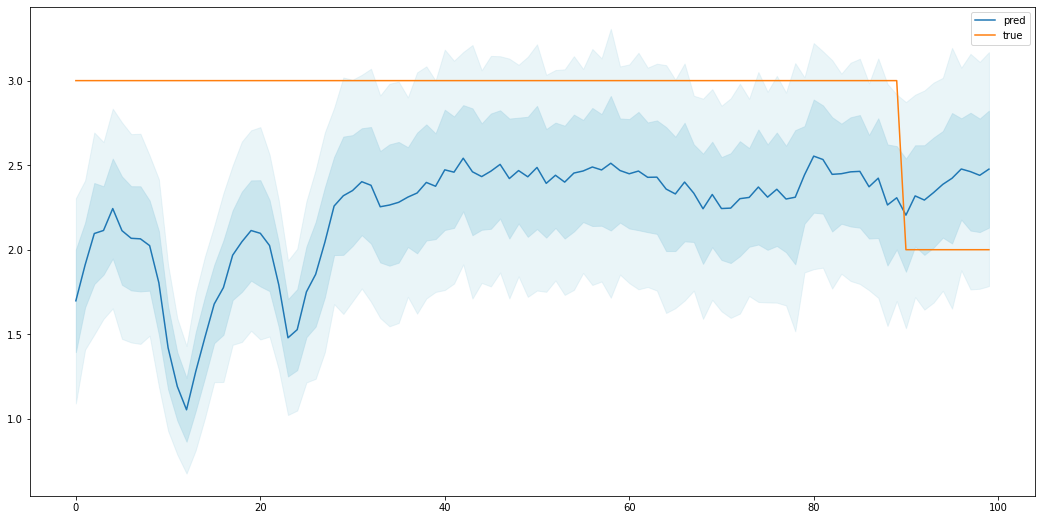

In [2]:
from src.lstm import visualise_regr_results

device='cuda:0'
mcdLSTM_regr = MCDLSTM(no_layers=3, input_size=12, hidden_dim=64, output_dim=1, drop_prob=0.5, device=device).to(device)
best_state = torch.load('models/lstm_model_regr_state_dict.pt', map_location=device)
mcdLSTM_regr.load_state_dict(best_state)

plt.figure(figsize=(18, 9))
visualise_regr_results(mcdLSTM_regr, seq_x_test[0:100], seq_y_test[0:100], device=device)
plt.figure(figsize=(18, 9))
visualise_regr_results(mcdLSTM_regr, seq_x_test[100:200], seq_y_test[100:200], device=device)

## Prawdopodobieństwa klasy (klasyfikacja)

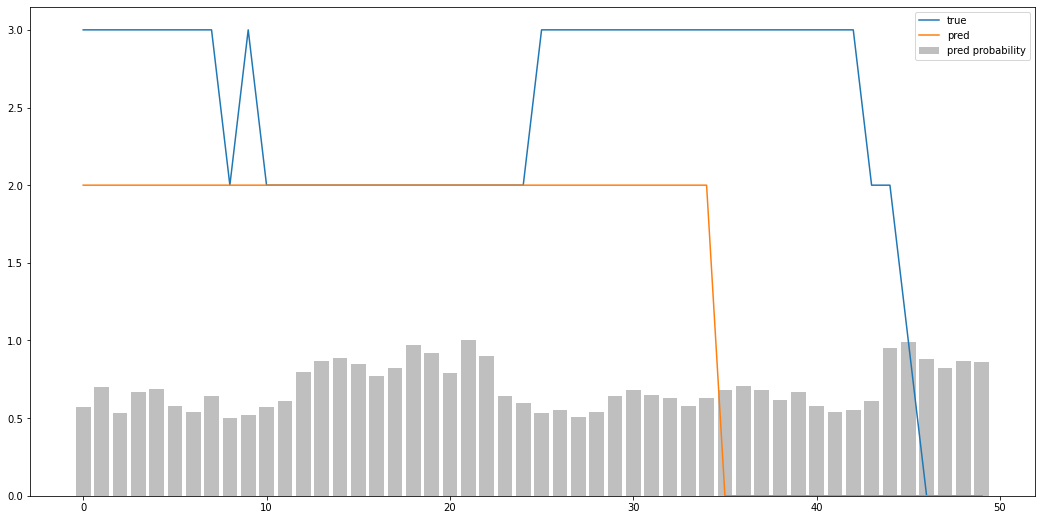

In [10]:
from src.lstm import visualise_clf_results

device='cuda:0'
mcdLSTM_clf = MCDLSTM(no_layers=3, input_size=12, hidden_dim=64, output_dim=4, drop_prob=0.5, device=device).to(device)
best_state = torch.load('models/lstm_model_clf_state_dict.pt', map_location=device)
mcdLSTM_clf.load_state_dict(best_state)

plt.figure(figsize=(18, 9))
visualise_clf_results(mcdLSTM_clf, seq_x_test[250:300], seq_y_test[250:300], device=device)